In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy as sp
from scipy import stats

%precision 3
%matplotlib inline
sns.set()


# 複数の説明変数を持つモデル

In [17]:
sales = pd.read_csv('../data/5-3-1-lm-model.csv')
sales.head(3)

,humidity,price,sales,temperature,weather
0,29.5,290,229.7,17.8,rainy
1,38.1,290,206.1,26.1,rainy
2,31.5,290,202.5,22.0,rainy


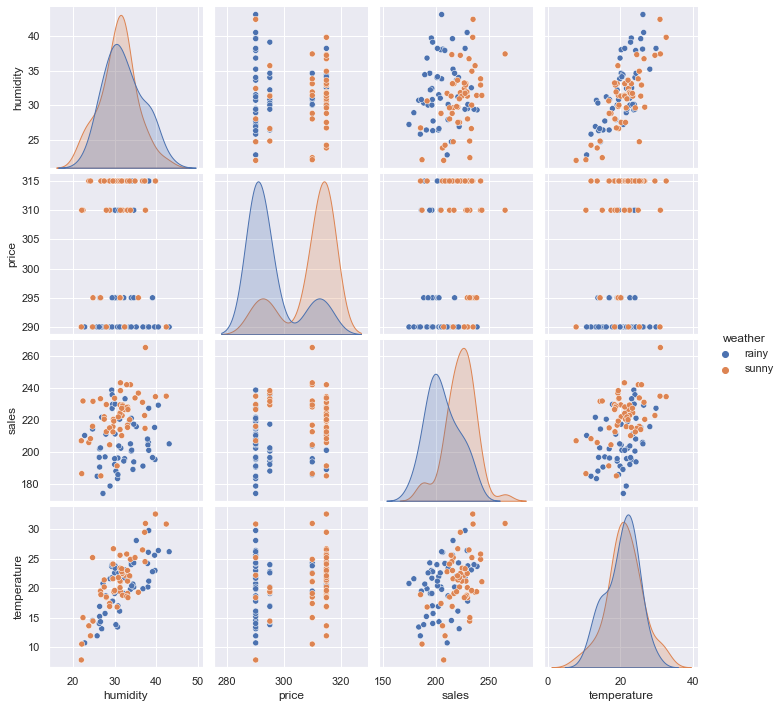

In [18]:
sns.pairplot(
    data=sales,
    hue='weather',
    # palette='gray'
)

## 悪い分析例: 変数が1つだけのモデルを作ること

- 複数の説明変数が必要なのに、1つだけを選んで使うこと
  - 例えば、説明変数に価格のみを使い、単回帰モデルを推定する

In [19]:
lm_ng = smf.ols(formula='sales ~ price', data=sales).fit()
lm_ng.params

Intercept    113.645406
price          0.332812
dtype: float64

In [20]:
sm.stats.anova_lm(lm_ng, typ=2)

,sum_sq,df,F,PR(>F)
price,1398.392322,1.0,4.970685,0.028064
Residual,27570.133578,98.0,NaN,NaN


- 上記の結果を踏まえると、価格は売上に対して、有意な影響をもっており、価格が上がると売上も増えるということ
  - つまり、売上を増やしたいのであれば、価格を上げることが良いということ


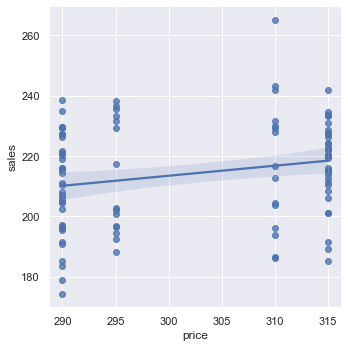

In [21]:
# 回帰直線
sns.lmplot(
    x='price', y='sales',
    data=sales,
    # scatter_kws={'color': 'black'},
    # line_kws={'color': 'black'},
)

## 説明変数同士の関係を調べる

- 天気によってデータを分割し、分割されたデータに対して回帰分析を行うという手法も過去には使われることがあった
- しかし、この手法は、説明変数同士の関係を考慮していないため、説明変数同士の関係を考慮したモデルを作ることができない


In [23]:
sales.groupby("weather").mean()

,humidity,price,sales,temperature
weather,,,,
rainy,32.126,295.5,205.924,20.422
sunny,30.852,309.5,222.718,21.102


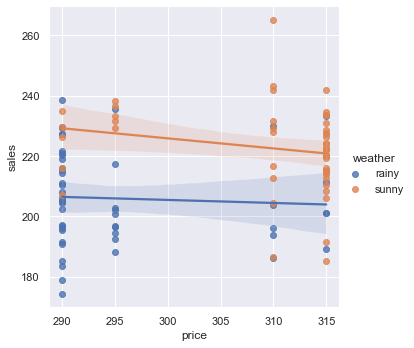

In [24]:
sns.lmplot(
    x="price",
    y="sales",
    data=sales,
    hue="weather",
)

## 複数の説明変数を持つモデル

- 説明変数に気温、湿度、価格を使い、重回帰モデルを推定する

In [27]:
# 複数の説明変数を持つモデルを推定
lm_sales = smf.ols(
    formula='sales ~ weather + humidity + temperature + price',
    data=sales,
).fit()
lm_sales.params

/Users/k-kakimoto/dev/ml_samples/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['typ']
  warnings.warn(msg, ValueWarning)


Intercept           278.627722
weather[T.sunny]     19.989119
humidity             -0.254055
temperature           1.603115
price                -0.329207
dtype: float64

## 悪い分析例: 通常の分散分析を検定(= Type I Anova)

- 説明変数が応答変数に影響を与えているといえるかどうか、検定を用いて判断
- Type I Anova は説明変数を入れ替えると、結果が変わってしまうため、説明変数同士の関係を考慮していない


In [28]:
# typ=1 = Type I Anova
sm.stats.anova_lm(lm_sales, typ=1).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,38.848,0.000
humidity,1.0,1779.601,1779.601,9.805,0.002
temperature,1.0,2076.845,2076.845,11.443,0.001
price,1.0,818.402,818.402,4.509,0.036
Residual,95.0,17242.717,181.502,NaN,NaN


In [29]:
# lm_sales と異なる順番で説明変数を入れ替えたモデルを推定
lm_sales_2 = smf.ols(
    formula='sales ~ weather + temperature + humidity + price',
    data=sales,
).fit()
# 検定結果
sm.stats.anova_lm(lm_sales_2, typ=1).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,38.848,0.000
temperature,1.0,3814.779,3814.779,21.018,0.000
humidity,1.0,41.667,41.667,0.230,0.633
price,1.0,818.402,818.402,4.509,0.036
Residual,95.0,17242.717,181.502,NaN,NaN


- Model1: sales ~ weather + humidity + temperature + price
- Model2: sales ~ weather + temperature + humidity + price

結果は一致しない

- 以下のように、回帰係数のt検定ならば説明変数の順番がもたらす問題は発生しないことがわかる

In [32]:
print('Model1: ')
lm_sales.summary().tables[1]

Model1: 


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


In [33]:
print('Model2: ')
lm_sales_2.summary().tables[1]

Model2: 


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,278.6277,46.335,6.013,0.000,186.641,370.615
weather[T.sunny],19.9891,3.522,5.675,0.000,12.997,26.982
temperature,1.6031,0.443,3.620,0.000,0.724,2.482
humidity,-0.2541,0.456,-0.558,0.578,-1.159,0.651
price,-0.3292,0.155,-2.123,0.036,-0.637,-0.021


## モデル選択と分散分析 (= Type II Anova)

- 説明変数を入れる順番を変えても検定の結果が変わらない分散分析をTYPE II ANOVAと呼ぶ
    - 厳密な実験結果に基づいて得られたデータならば TYPE I ANOVA の持つ問題は大きくない

### モデル選択と分散分析

sales ~ 1 + weather + humidity + temperature + price

In [34]:
# Nullモデルの残差平方和
model_null = smf.ols(formula='sales ~ 1', data=sales).fit()
resid_sq_null = np.sum(model_null.resid ** 2)
resid_sq_null

28968.526

In [35]:
# 天気モデルの残差平方和
model_1 = smf.ols(formula='sales ~ weather', data=sales).fit()
resid_sq_1 = np.sum(model_1.resid ** 2)
resid_sq_1

21917.565

In [36]:
resid_sq_null - resid_sq_1

7050.961

In [37]:
sm.stats.anova_lm(model_1, typ=1).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,31.527,0.0
Residual,98.0,21917.565,223.649,NaN,NaN


In [38]:
# 天気+湿度モデルの残差平方和
model_2 = smf.ols(
    formula='sales ~ weather + humidity',
    data=sales
).fit()
resid_sq_2 = np.sum(model_2.resid ** 2)
resid_sq_2

20137.964

In [39]:
resid_sq_1 - resid_sq_2

1779.601

In [41]:
sm.stats.anova_lm(model_2, typ=1).round(3)

,df,sum_sq,mean_sq,F,PR(>F)
weather,1.0,7050.961,7050.961,33.963,0.000
humidity,1.0,1779.601,1779.601,8.572,0.004
Residual,97.0,20137.964,207.608,NaN,NaN


つまり、分散分析は1つずつ説明変数を増やしていき、説明変数が増えることによって現象する残差平方和の大きさに基づいて説明変数の持つ効果の大きさを定量化している